# Imports

In [ ]:
import matplotlib.pyplot as plt
import optuna
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from src.preprocessing import preprocess_data
from src.utils.compute_metrics import compute_and_store_metrics
from src.utils.confusion_matrix import plot_confusion_matrix
from src.utils.load_data import load_data


# Load Data

In [15]:
X, y = preprocess_data(load_data())

# Model

## Base Logistic Regression

In [16]:
## Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [17]:
## Model
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[
    :, 1
]  # Probability estimates for the positive class (default)

In [18]:
threshold = 0.5
y_pred = (y_pred_proba >= threshold).astype(int)

### Evaluation

In [19]:
classification_rep = classification_report(y_test, y_pred)
clf_matrix = confusion_matrix(y_test, y_pred)

/home/augustin/projects/xhec_dsb/05_intro_to_finance_for_data_scientists/.venv/lib64/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/augustin/projects/xhec_dsb/05_intro_to_finance_for_data_scientists/.venv/lib64/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/augustin/projects/xhec_dsb/05_intro_to_finance_for_data_scientists/.venv/lib64/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0

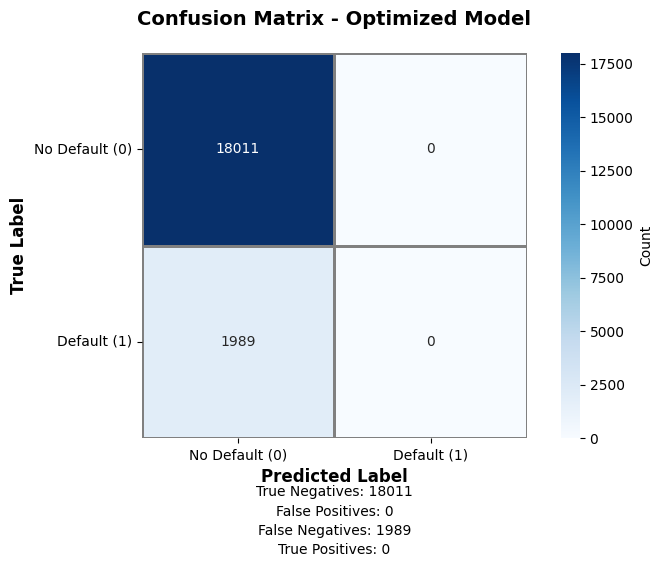


Model Metrics:
Accuracy:  0.9005 (90.05%)
Precision: 0.0000 (0.00%)
Recall:    0.0000 (0.00%)
F1-Score:  0.0000 (0.00%)


In [20]:
plot_confusion_matrix(y_test, y_pred, cmap="Blues")

## Hyperparameter fine-tuning (Optuna)

In [ ]:
def objective(trial):
    C = trial.suggest_float("C", 1e-4, 1e2, log=True)  # Regularization strength
    penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet"])
    solver = trial.suggest_categorical("solver", ["liblinear", "saga"])
    max_iter = trial.suggest_int("max_iter", 100, 1000)
    threshold = trial.suggest_float("threshold", 0.1, 0.9)

    if penalty == "l1" and solver not in ["liblinear", "saga"]:
        solver = "liblinear"
    elif penalty == "elasticnet":
        solver = "saga"
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
    else:
        l1_ratio = None

    # Create and train the model
    if penalty == "elasticnet":
        model = LogisticRegression(
            C=C,
            penalty=penalty,
            solver=solver,
            max_iter=max_iter,
            l1_ratio=l1_ratio,
            random_state=42,
        )
    else:
        model = LogisticRegression(
            C=C, penalty=penalty, solver=solver, max_iter=max_iter, random_state=42
        )

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_proba = model.predict_proba(X_test)[
        :, 1
    ]  # Probability estimates for the positive class (default)
    y_pred = (y_pred_proba >= threshold).astype(int)

    # Calculate F1-score (or any other metric you prefer)
    from sklearn.metrics import f1_score

    score = f1_score(y_test, y_pred)

    return score


# Create and run the study
study = optuna.create_study(direction="maximize")  # Maximize F1-score
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n" + "=" * 60)
print("BEST HYPERPARAMETERS")
print("=" * 60)
print(f"Best F1-Score: {study.best_value:.4f}")
print("\nBest Parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-10-15 15:48:23,515] A new study created in memory with name: no-name-03554a1f-bb65-4eb4-902e-a1f0ce1797bd


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-15 15:48:24,113] Trial 0 finished with value: 0.2772159428911362 and parameters: {'C': 0.008730025270831646, 'penalty': 'l1', 'solver': 'saga', 'max_iter': 286, 'threshold': 0.14105783609821787}. Best is trial 0 with value: 0.2772159428911362.
[I 2025-10-15 15:48:24,853] Trial 1 finished with value: 0.0 and parameters: {'C': 21.15640584942042, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 637, 'threshold': 0.8409496935558683}. Best is trial 0 with value: 0.2772159428911362.
[I 2025-10-15 15:48:25,725] Trial 2 finished with value: 0.0 and parameters: {'C': 11.592788166018547, 'penalty': 'l1', 'solver': 'saga', 'max_iter': 969, 'threshold': 0.3249324409219334}. Best is trial 0 with value: 0.2772159428911362.
[I 2025-10-15 15:48:25,823] Trial 3 finished with value: 0.2026681040291066 and parameters: {'C': 0.0004912942024368013, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 284, 'threshold': 0.15708190040982706}. Best is trial 0 with value: 0.2772159428911362.
[I 2025-10-

### Optimized Model Evaluation

In [ ]:
# Train the final model with best parameters
best_params = study.best_params

if best_params.get("penalty") == "elasticnet":
    optimized_model = LogisticRegression(
        C=best_params["C"],
        penalty=best_params["penalty"],
        solver=best_params["solver"],
        max_iter=best_params["max_iter"],
        l1_ratio=best_params.get("l1_ratio"),
        class_weight="balanced",
        random_state=42,
    )
else:
    optimized_model = LogisticRegression(
        C=best_params["C"],
        penalty=best_params["penalty"],
        solver=best_params["solver"],
        max_iter=best_params["max_iter"],
        class_weight="balanced",
        random_state=42,
    )

optimized_model.fit(X_train, y_train)
y_pred_proba_optimized = optimized_model.predict_proba(X_test)[:, 1]
y_pred_optimized = (y_pred_proba_optimized >= best_params["threshold"]).astype(int)

📈 Model Comparison:
   Metric  Base Model  Optimized Model  Improvement
 Accuracy     0.90055         0.235300       -73.87
Precision     0.00000         0.113429          inf
   Recall     0.00000         0.981398          inf
 F1-Score     0.00000         0.203355          inf


/home/augustin/projects/xhec_dsb/05_intro_to_finance_for_data_scientists/.venv/lib64/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


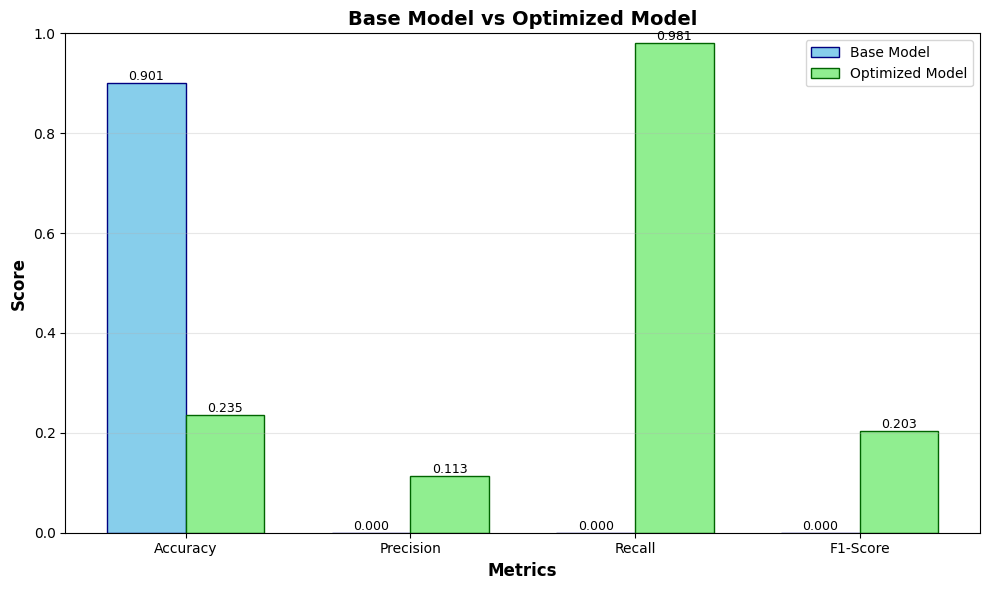

In [ ]:
# Compare base model vs optimized model
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

comparison_df = pd.DataFrame(
    {
        "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
        "Base Model": [
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
            f1_score(y_test, y_pred),
        ],
        "Optimized Model": [
            accuracy_score(y_test, y_pred_optimized),
            precision_score(y_test, y_pred_optimized),
            recall_score(y_test, y_pred_optimized),
            f1_score(y_test, y_pred_optimized),
        ],
    }
)

comparison_df["Improvement"] = (
    (comparison_df["Optimized Model"] - comparison_df["Base Model"])
    / comparison_df["Base Model"]
    * 100
).round(2)

print("Model Comparison:")
print("=" * 70)
print(comparison_df.to_string(index=False))
print("=" * 70)

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(comparison_df))
width = 0.35

bars1 = ax.bar(
    [i - width / 2 for i in x],
    comparison_df["Base Model"],
    width,
    label="Base Model",
    color="skyblue",
    edgecolor="navy",
)
bars2 = ax.bar(
    [i + width / 2 for i in x],
    comparison_df["Optimized Model"],
    width,
    label="Optimized Model",
    color="lightgreen",
    edgecolor="darkgreen",
)

ax.set_xlabel("Metrics", fontsize=12, fontweight="bold")
ax.set_ylabel("Score", fontsize=12, fontweight="bold")
ax.set_title("Base Model vs Optimized Model", fontsize=14, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(comparison_df["Metric"])
ax.legend()
ax.grid(True, alpha=0.3, axis="y")
ax.set_ylim([0, 1])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{height:.3f}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

plt.tight_layout()
plt.show()

### Model Comparison

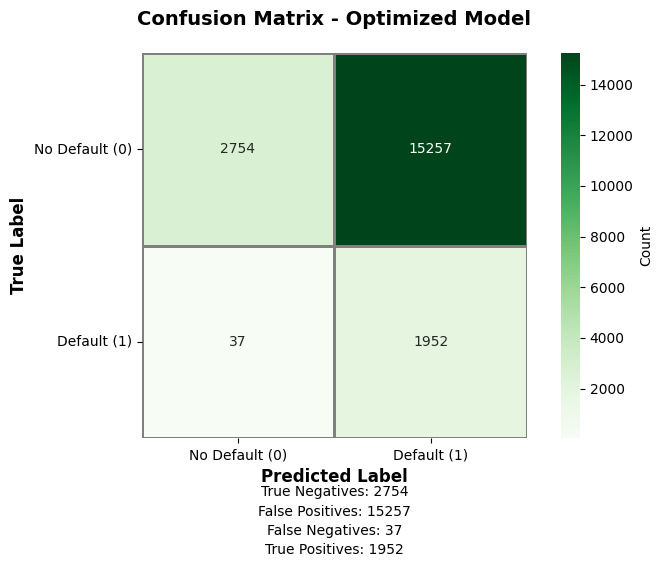


Model Metrics:
Accuracy:  0.2353 (23.53%)
Precision: 0.1134 (11.34%)
Recall:    0.9814 (98.14%)
F1-Score:  0.2034 (20.34%)


In [24]:
plot_confusion_matrix(y_test, y_pred_optimized)

### Train Final Model with Best Parameters

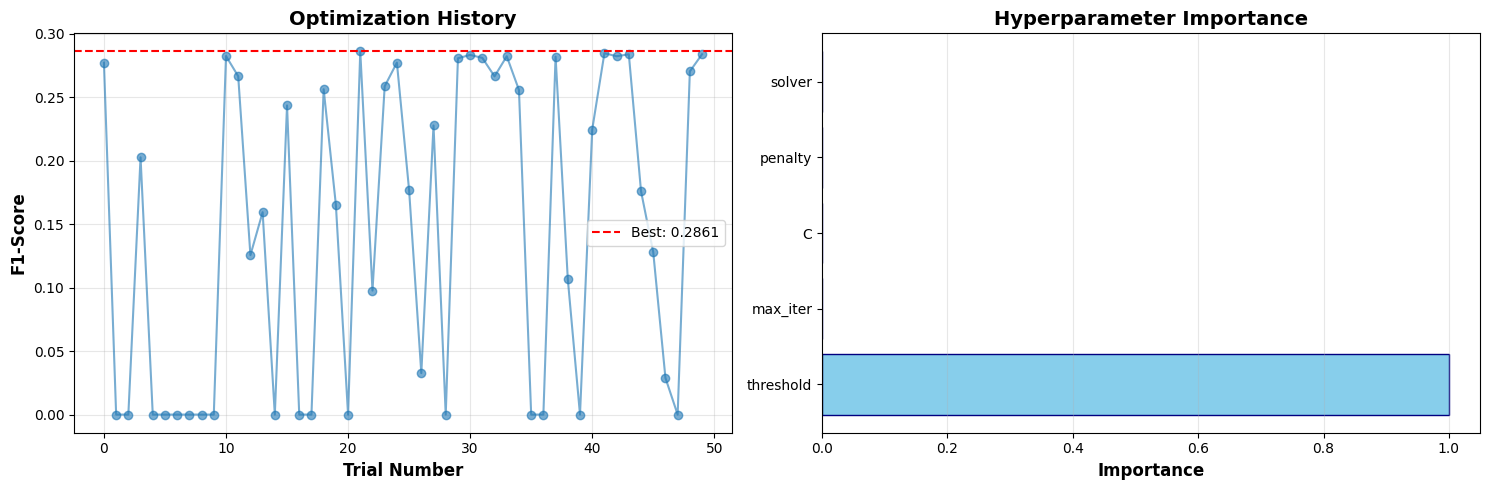

In [ ]:
# Plot optimization history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Optimization History
trials_df = study.trials_dataframe()
axes[0].plot(trials_df.index, trials_df["value"], marker="o", linestyle="-", alpha=0.6)
axes[0].axhline(
    y=study.best_value, color="r", linestyle="--", label=f"Best: {study.best_value:.4f}"
)
axes[0].set_xlabel("Trial Number", fontsize=12, fontweight="bold")
axes[0].set_ylabel("F1-Score", fontsize=12, fontweight="bold")
axes[0].set_title("Optimization History", fontsize=14, fontweight="bold")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Parameter Importance
from optuna.importance import get_param_importances  # noqa: E402

importances = get_param_importances(study)
params = list(importances.keys())
values = list(importances.values())

axes[1].barh(params, values, color="skyblue", edgecolor="navy")
axes[1].set_xlabel("Importance", fontsize=12, fontweight="bold")
axes[1].set_title("Hyperparameter Importance", fontsize=14, fontweight="bold")
axes[1].grid(True, alpha=0.3, axis="x")

plt.tight_layout()
plt.show()

Logstic Regression model not good to predict default (low F1-score).

In [26]:
compute_and_store_metrics(y_test, y_pred_optimized, model_name="Logistic Regression")